In [112]:
import os
import sys
import numpy as np
import pylab as pl
import json
import geopandas as gpd
import urllib
import requests
import pandas as pd
import io
import shapely
from fiona.crs import from_epsg

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# 1.1 download the NYC Public Use Microdata Areas (PUMA) geometry from the NYC Open Data API and read it in with geopandas¶

In [2]:
urllib.request.urlretrieve("https://data.cityofnewyork.us/api/geospatial/cwiz-gcty?method=export&format=Shapefile",
                           "file.gz")

('file.gz', <http.client.HTTPMessage at 0x7fa67d8308d0>)

In [3]:

!mv file.gz $PUIDATA

In [4]:

!unzip $PUIDATA/file.gz -d $PUIDATA

Archive:  /nfshome/ah4412/PUIdata/file.gz
  inflating: /nfshome/ah4412/PUIdata/geo_export_010507d0-1811-4fe4-bc09-cdd9ca51ff7f.dbf  
  inflating: /nfshome/ah4412/PUIdata/geo_export_010507d0-1811-4fe4-bc09-cdd9ca51ff7f.shp  
  inflating: /nfshome/ah4412/PUIdata/geo_export_010507d0-1811-4fe4-bc09-cdd9ca51ff7f.shx  
  inflating: /nfshome/ah4412/PUIdata/geo_export_010507d0-1811-4fe4-bc09-cdd9ca51ff7f.prj  


In [87]:
pumashp = gpd.GeoDataFrame.from_file("/nfshome/ah4412/PUIdata/geo_export_010507d0-1811-4fe4-bc09-cdd9ca51ff7f.shp")

In [8]:

# Reading the first 5 rows of shape file

pumashp.head()

,puma,shape_area,shape_leng,geometry
0,3701,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...
1,3702,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,..."
2,3703,2.670137e+08,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...
3,3704,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,..."
4,4015,8.105438e+07,50007.415493,POLYGON ((-73.95374853778468 40.63858633758547...


In [88]:
pumashp.crs

{'init': 'epsg:4326'}

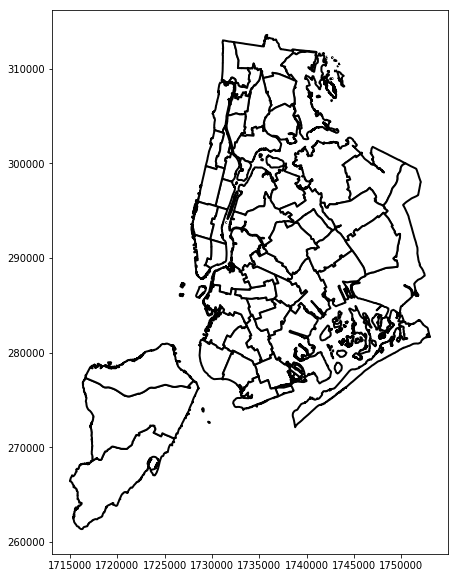

In [10]:
naec = '+proj=eqdc +lat_0=40 +lon_0=-96 +lat_1=20 +lat_2=60 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs'

# Then plot
pumashp.to_crs(naec).plot(figsize=(10,10), color = "white", edgecolor = "black", lw=2)

Caption: The above map shows the area covered in the PUMA NYC dataset shape file. This covers the 5 boroughs of NYC, broken into PUMAs (Public Use Microdata Areas)

# 2. American Fact Finder data on percentage of houses with broadband internet access

In [13]:

#read in in the variables available. the info you need is in the 1year ACS data
url = "https://api.census.gov/data/2016/acs/acs1/variables.json"
resp = requests.request('GET', url)
aff1y = json.loads(resp.text)

In [14]:
#turning things into arrays to enable broadcasting
#Python3
affkeys = np.array(list(aff1y['variables'].keys()))
#Python2
#affkeys = np.array(aff1y['variables'].keys())


In [15]:

#extracting variables of B28002 that contain "broadband"
[(k, aff1y['variables'][k]['label'])  for k in affkeys if k.startswith ("B28002") and 
 'Broadband' in aff1y['variables'][k]['label']]

[('B28002_007E',
  'Estimate!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL'),
 ('B28002_008E',
  'Estimate!!Total!!With an Internet subscription!!Broadband such as cable, fiber optic or DSL!!Broadband such as cable, fiber optic or DSL with no other type of Internet subscription'),
 ('B28002_004E',
  'Estimate!!Total!!With an Internet subscription!!Broadband of any type')]

In [16]:

#keyword for the number of households
keyNhouseholds = 'B28002_001E'
aff1y['variables'][keyNhouseholds]

{'attributes': 'B28002_001M,B28002_001EA',
 'concept': 'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 'group': 'B28002',
 'label': 'Estimate!!Total',
 'limit': 0,
 'predicateType': 'int'}

In [20]:
#keyword for the number of households with broarband access
keyNBB = 'B28002_004E'
aff1y['variables'][keyNBB]

{'attributes': 'B28002_004M,B28002_004EA',
 'concept': 'PRESENCE AND TYPES OF INTERNET SUBSCRIPTIONS IN HOUSEHOLD',
 'group': 'B28002',
 'label': 'Estimate!!Total!!With an Internet subscription!!Broadband of any type',
 'limit': 0,
 'predicateType': 'int'}

In [30]:

%run 'myAPI.py'

In [39]:
# getting the broadband access number of households
url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNBB +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp = requests.request('GET', url).content
pumaBB = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

pumaBB.head()

,B28002_004E,NAME,state,public use microdata area,Unnamed: 4
0,32607,"St. Lawrence County PUMA, New York",36,100,NaN
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,41210,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


In [42]:
#getting the first row of the table: the total number of households
url = "https://api.census.gov/data/2016/acs/acs1?get=" + keyNhouseholds +\
",NAME&for=public%20use%20microdata%20area:*&in=state:36&key=" + myAPI
resp = requests.request('GET', url).content
pumaPP = pd.read_csv(io.StringIO(resp.decode('utf-8').replace('[','').replace(']','')))

pumaPP.head()

,B28002_001E,NAME,state,public use microdata area,Unnamed: 4
0,40479,"St. Lawrence County PUMA, New York",36,100,NaN
1,67092,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN
2,51614,"Warren & Washington Counties PUMA, New York",36,300,NaN
3,44300,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN
4,61146,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN


## 2.2 generate a feature for the percentage of households with broadband access

In [47]:
pumaBB['B28002_001E'] = pumaPP['B28002_001E']
pumaBB['pcBB'] = (pumaBB['B28002_004E'] / pumaBB['B28002_001E']) * 100

pumaBB.head()

,B28002_004E,NAME,state,public use microdata area,Unnamed: 4,B28002_001E,pcBB
0,32607,"St. Lawrence County PUMA, New York",36,100,NaN,40479,80.552879
1,50811,"Clinton, Franklin, Essex & Hamilton Counties P...",36,200,NaN,67092,75.733321
2,41210,"Warren & Washington Counties PUMA, New York",36,300,NaN,51614,79.842678
3,36075,Herkimer (North & Central) & Oneida (Outer) Co...,36,401,NaN,44300,81.433409
4,47786,Oneida County (Central)--Greater Utica & Rome ...,36,402,NaN,61146,78.150656


## 2.3 Now compare it with the AFF published "percentage of households with broadband access" which is a feature available through their website but that cannot be downloaded directly from the API. It compiled by AFF the same way we did above

Manually you can download the GCT Geographic Comparison Tables. Download the GCT table that contains the percentage of households in each PUMA with broadband internet subscription as follows:

https://factfinder.census.gov/ -> Advanced Search -> Show me all

- Topics: Product Type -> Geography Comparison Table 

select the PERCENT OF HOUSEHOLDS WITH A BROADBAND INTERNET SUBSCRIPTION at our geography granularity (PUMA) and click Download below. This will generate the table on the fly and you can click again on Download.

Move the file into the PUIdata directory, unzip it and load it with pandas.

Your table shold be labeled as: GCT2801

One more hurdle: you need to move this data to jupyterhub/compute, and the link is not something you can copy and paste! Two solutions:

-easier but less preferible: upload the table you downloaded locally to github AWS, or else where, and download it from compute

-otherwise, learn how to do it with sftp from your local terminal: these are the steps

ON YOUR LOCAL MACHINE where you downloaded the table (which was downloaded as aff_download.zip for me in my ~/Downloads folder) type the following sftp command

 fbianco@Federicas-MacBook-Air:~$ sftp fbianco@staging.cusp.nyu.edu
Input your password Password: 
 Connected to staging.cusp.nyu.edu.

This should open an sftp promopt (you should see sftp> at the beginning of the line). Go to the PUI directory (for me /home/fbianco/PUIdata)

 sftp> cd /home/fbianco/PUIdata             
Use the sftp command put to copy the file from the local to the remote machine to compute, making sure you use the full path (unless the file was downloaded in your local directory in the local machine)

 sftp> put /Users/fbianco/Downloads/aff_download.zip
You should see:

        Uploading /Users/fbianco/Downloads/aff_download.zip to ....

And the file can be unzipped and read into your code with pandas. I leave the read in line below for your convenience, those are the only variables you need.

In [48]:
!unzip $PUIDATA/ACS_16_1YR_GCT2801.ST50.zip -d $PUIDATA

Archive:  /nfshome/ah4412/PUIdata/ACS_16_1YR_GCT2801.ST50.zip
  inflating: /nfshome/ah4412/PUIdata/ACS_16_1YR_GCT2801.ST50_with_ann.csv  
  inflating: /nfshome/ah4412/PUIdata/ACS_16_1YR_GCT2801.ST50_metadata.csv  
  inflating: /nfshome/ah4412/PUIdata/ACS_16_1YR_GCT2801.ST50.txt  
  inflating: /nfshome/ah4412/PUIdata/aff_download_readme_ann.txt  


In [58]:
bbpc = pd.read_csv(os.getenv("PUIDATA") + "/ACS_16_1YR_GCT2801.ST50_with_ann.csv",
            usecols=["GCT_STUB.target-geo-id2","HC01","HC02"])

bbpc.head()

,GCT_STUB.target-geo-id2,HC01,HC02
0,Target Geo Id2,Percent,Margin of Error
1,01,74.7,0.5
2,0100100,70.9,2.5
3,0100200,80.5,2.7
4,0100301,87.0,2.8


In [59]:
bbpc.drop(0, inplace=True)
bbpc.head()

,GCT_STUB.target-geo-id2,HC01,HC02
1,01,74.7,0.5
2,0100100,70.9,2.5
3,0100200,80.5,2.7
4,0100301,87.0,2.8
5,0100302,81.9,2.9


In [65]:
bbpc['HC01'].astype(float)
bbpc['HC02'].astype(float)
bbpc['GCT_STUB.target-geo-id2'].astype(int)
bbpc.head()

,GCT_STUB.target-geo-id2,HC01,HC02
1,01,74.7,0.5
2,0100100,70.9,2.5
3,0100200,80.5,2.7
4,0100301,87.0,2.8
5,0100302,81.9,2.9


notice 2 things:

- that the Target Geo Id2: GCT_STUB.target-geo-id2 is a 7 digits number. See my comment above about it. 
- that there is a weird double header. You can deal with it in one of 2 ways: either reread the file in skipping one row and using the second row as header, or remove that row (for example with bbpc.drop(0, inplace=True)) but also then you should check the *type* of your GCT_STUB.target-geo-id2 feature! The fact that pandas had to read in a column with nombers and characters forced it to read it as a string, and you need to convert it (.astype(int)) to merge it easily with the API acquired data.

In the API dataframe the PUMA id was a 4 digit number. If you have them both as integers and you remove the initial three digits (for example by subtracting 360000 from each value wich you can do as bbpc["gid"] = bbpc.gid - 3600000 then you can merge on the puma id

In [77]:
bbpc["gid"] = bbpc['GCT_STUB.target-geo-id2'].astype(int) - 3600000
bbpc.head()

,GCT_STUB.target-geo-id2,HC01,HC02,gid
1,01,74.7,0.5,-3599999
2,0100100,70.9,2.5,-3499900
3,0100200,80.5,2.7,-3499800
4,0100301,87.0,2.8,-3499699
5,0100302,81.9,2.9,-3499698


## check that the percentage of households with broadband you generated and the one you red in from the table you downloaded manually are the same

In [84]:
diff_ = pumaBB.merge(bbpc, right_on="gid", 
                     left_on="public use microdata area")[["pcBB", "HC01"]]

diff_["HC01"] = diff_["HC01"].astype(float)
diff_["diff"] = np.abs(diff_["pcBB"] - diff_["HC01"].astype(float))

diff_.describe()


,pcBB,HC01,diff
count,145.000000,145.000000,145.000000
mean,81.845478,81.843448,0.026217
std,7.063369,7.065358,0.014480
min,54.932945,54.900000,0.000178
25%,77.770257,77.800000,0.012252
50%,82.826141,82.800000,0.027230
75%,87.305077,87.300000,0.039090
max,93.404143,93.400000,0.049872


# 3 Plot a choropleth of NYC broadband access

## 3.1 Merge with the puma geodataframe and plot a choropleth of the percentage of households with broadband access

In [93]:
#choropleth of the percentage of internet axcess
pumashp['puma'] = pumashp['puma'].astype(int)
pumashp = pumashp.merge(pumaBB, right_on="public use microdata area", left_on="puma")
pumashp.head()

,puma,shape_area,shape_leng,geometry,B28002_004E,NAME,state,public use microdata area,Unnamed: 4,B28002_001E,pcBB
0,3701,9.792852e+07,53227.144461,POLYGON ((-73.89641133483133 40.90450452082026...,35529,"NYC-Bronx Community District 8--Riverdale, Fie...",36,3701,NaN,42158,84.275820
1,3702,1.889860e+08,106050.002302,"POLYGON ((-73.8442314689986 40.86942035096838,...",34030,"NYC-Bronx Community District 12--Wakefield, Wi...",36,3702,NaN,49817,68.310015
2,3703,2.670137e+08,304071.257466,(POLYGON ((-73.78833349834532 40.8346671297593...,36716,"NYC-Bronx Community District 10--Co-op City, P...",36,3703,NaN,44329,82.826141
3,3704,1.062129e+08,47970.901277,"POLYGON ((-73.84792614069238 40.8713422330779,...",32269,NYC-Bronx Community District 11--Pelham Parkwa...,36,3704,NaN,44476,72.553737
4,4015,8.105438e+07,50007.415493,POLYGON ((-73.95374853778468 40.63858633758547...,44079,NYC-Brooklyn Community District 14--Flatbush &...,36,4015,NaN,55953,78.778618


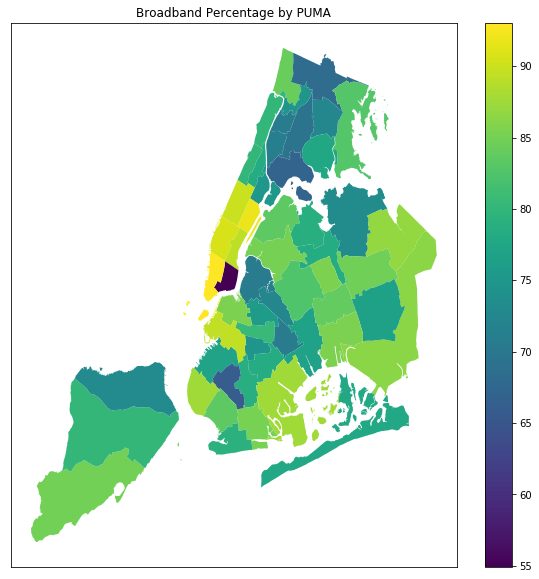

In [95]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
pumashp.plot(column='pcBB',cmap='viridis',alpha=1,
                  linewidth=0.1,ax=ax, legend=True)
plt.title("Broadband Percentage by PUMA");

Caption: The plot shows percentage of households with broadband by PUMA. The highest percentage areas appear to be in lower Manhattan.

# 4. LinkNYC: assess whether the locations of the linkNYC stations are supplying internet where it is needed.

acquire the linkNYC locations and prepare them into a dataframe read it in from the HW7_fb55 folder in : https://github.com/fedhere/PUI2018_fb55

Notice that you can also get a linkNYC locations shapefile from NYC open data, as I did to generate this, but I want you do to do some extra coordinates gymnastics for practice so use the one I provide.

In [105]:
linkNYC = pd.read_csv('https://raw.githubusercontent.com/fedhere/PUI2018_fb55/master/HW7_fb55/linkNYClocations.csv')

linkNYC.head()

,Unnamed: 0,link_site,longitude,date_link_,latitude
0,0,bk-01-138951,-73.942489,2017-07-01,40.701668
1,1,bk-01-109091,-73.942169,2017-07-01,40.701542
2,2,bk-01-143982,-73.942239,2017-07-01,40.701930
3,3,bk-01-109262,-73.942918,2017-04-28,40.705060
4,4,bk-01-125268,-73.953439,2017-03-31,40.728133


In [101]:
linkNYC.shape

(1414, 5)

## combine long lat into a column like you did in the lab to greate a "geometry" column for the dataframe, then convert the dataframe into a GeoDataFrame linkNYC and set native coordinates frame to lat/lon as you did in the lab

In [106]:
# combine lat and lon to one column
linkNYC['lonlat']=list(zip(linkNYC.longitude, linkNYC.latitude))
linkNYC.head()

,Unnamed: 0,link_site,longitude,date_link_,latitude,lonlat
0,0,bk-01-138951,-73.942489,2017-07-01,40.701668,"(-73.94248859, 40.70166753)"
1,1,bk-01-109091,-73.942169,2017-07-01,40.701542,"(-73.9421692831, 40.7015421938)"
2,2,bk-01-143982,-73.942239,2017-07-01,40.701930,"(-73.9422392385, 40.7019303439)"
3,3,bk-01-109262,-73.942918,2017-04-28,40.705060,"(-73.94291758, 40.70506042)"
4,4,bk-01-125268,-73.953439,2017-03-31,40.728133,"(-73.953439, 40.728133)"


In [107]:
# Create Point Geometry for based on lonlat column
linkNYC['geometry'] = linkNYC[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
linkNYC.head()

,Unnamed: 0,link_site,longitude,date_link_,latitude,lonlat,geometry
0,0,bk-01-138951,-73.942489,2017-07-01,40.701668,"(-73.94248859, 40.70166753)",POINT (-73.94248859 40.70166753)
1,1,bk-01-109091,-73.942169,2017-07-01,40.701542,"(-73.9421692831, 40.7015421938)",POINT (-73.9421692831 40.7015421938)
2,2,bk-01-143982,-73.942239,2017-07-01,40.701930,"(-73.9422392385, 40.7019303439)",POINT (-73.94223923850001 40.7019303439)
3,3,bk-01-109262,-73.942918,2017-04-28,40.705060,"(-73.94291758, 40.70506042)",POINT (-73.94291758 40.70506042)
4,4,bk-01-125268,-73.953439,2017-03-31,40.728133,"(-73.953439, 40.728133)",POINT (-73.953439 40.728133)


In [111]:
linkNYC = gpd.GeoDataFrame(linkNYC)

In [113]:
linkNYC.crs = from_epsg(4326)

## plot the location of the linkNYC stations on top of a choropleth of broadband access percentage in 5 equal intervals
I have also color coded the station by how long ago they have been installed, using the date datetime variable

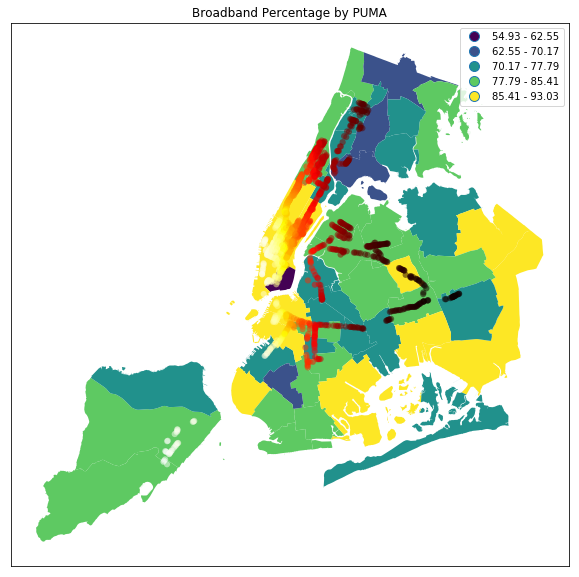

In [120]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
base = pumashp.plot(column='pcBB',cmap='viridis',alpha=1,
                  linewidth=0.1,ax=ax, legend=True, scheme="Equal_interval", k=5)
linkNYC.plot(column = 'lonlat', cmap='hot_r', alpha=0.5, linewidth=0.1, ax=ax);
plt.title("Broadband Percentage by PUMA");

Caption: Location of the linkNYC stations on top of a choropleth of broadband access percentage in 5 equal intervals. LinkNYC stations appear to be mostly in Manhattan.